# Reconocimiento Facial

se definen una serie de funciones que permitan automatizar el proceso completo.

* `pipeline_deteccion_imagen()`: detectar e identificar las personas de una imagen.

* `pipeline_deteccion_video()`: detectar e identificar las personas de un vídeo.

* `pipeline_deteccion_webcam()`: detectar e identificar las personas de un vídeo de entrada por webcam. Esta función requiere de abrir una ventana emergente de visualización, por lo que no puede utilizarse en google colab.

* `crear_diccionario_referencias()`: crear un diccionario con los embeddings de referencia para cada persona.

In [60]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install facenet_pytorch

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Librerías
# ==============================================================================
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import warnings
import typing
import logging
import os
import platform
import glob
import PIL
import facenet_pytorch
from typing import Union, Dict
from PIL import Image
from facenet_pytorch import MTCNN
from facenet_pytorch import InceptionResnetV1
from urllib.request import urlretrieve
from tqdm import tqdm 
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine

ModuleNotFoundError: No module named 'cv2'

In [63]:
warnings.filterwarnings('ignore')

logging.basicConfig(
    format = '%(asctime)-5s %(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.WARNING,
)


# Funciones para la detección, extracción, embedding, identificación y gráficos

* `def detectar_caras()`

* `def mostrar_bboxes()`

* `def mostrar_bboxes_cv2()`

* `def extraer_caras()`

* `def calcular_embeddings()`

* `def identificar_caras()`

* `def crear_diccionario_referencias()`

* `def pipeline_deteccion_image()`

* `def pipeline_deteccion_video()`

* `def pipeline_deteccion_webcam()`



## Función --> Detectar caras

In [64]:
def detectar_caras(imagen: Union[PIL.Image.Image, np.ndarray],
                   detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                   keep_all: bool        = True,
                   min_face_size: int    = 20,
                   thresholds: list      = [0.6, 0.7, 0.7],
                   device: str           = None,
                   min_confidence: float = 0.5,
                   fix_bbox: bool        = True,
                   verbose               = False)-> np.ndarray:
    """
    Detectar la posición de caras en una imagen empleando un detector MTCNN.
    
    Parameters
    ----------
    
    imagen: PIL.Image, np.ndarray
        PIL Image o numpy array con la representación de la imagen.

    detector : facenet_pytorch.models.mtcnn.MTCNN
        Default: None
        Modelo ``MTCNN`` empleado para detectar las caras de la imagen. Si es
        ``None`` se inicializa uno nuevo. La inicialización del modelo puede
        tardar varios segundos, por lo que, en ciertos escenarios, es preferible
        inicializarlo al principio del script y pasarlo como argumento.
        
    keep_all: bool
        Default: True
        Si `True`, se devuelven todas las caras detectadas en la imagen.

    min_face_size : int
        Default: 20
        Tamaño mínimo de que deben tener las caras para ser detectadas por la red 
        MTCNN.
        
    thresholds: list
        Default: [0.6, 0.7, 0.7]
        Límites de detección de cada una de las 3 redes que forman el detector MTCNN.
    
    device: str
        Default: None
        Device donde se ejecuta el modelo. Si el detector MTCNN, se pasa como
        argumento, no es necesario.

    min_confidence : float
        Default: 0.5
        confianza (probabilidad) mínima que debe de tener la cara detectada para
        que se incluya en los resultados.

    fix_bbox : bool
        Default: True
        Acota las dimensiones de las bounding box para que no excedan las
        dimensiones de la imagen. Esto evita problemas cuando se intenta
        representar las bounding box de caras que están en el margen de la
        imagen.

    verbose : bool
        Default: False
        Mostrar información del proceso por pantalla.
        
        
    Returns
    ----------
    numpy.ndarray
        Numpy array con las bounding box de cada cara detectada. Cada bounding
        box es a su vez una array formada por 4 valores que definen las coordenadas
        de la esquina superior-izquierda y la esquina inferior-derecha.
        
             (box[0],box[1])------------
                    |                  |
                    |                  |
                    |                  |
                    ------------(box[0],box[1])
                    
        Las bounding box devueltas por el detector ``MTCNN`` están definidas por
        valores de tipo `float`. Esto supone un problema para la posterior 
        representación con matplotlib, por lo que se convierten a tipo `int`.

    """
    
    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`imagen` debe ser `np.ndarray, PIL.Image`. Recibido {type(imagen)}."
        )

    if detector is None:
        logging.info('Iniciando detector MTCC')
        detector = MTCNN(
                        keep_all      = keep_all,
                        min_face_size = min_face_size,
                        thresholds    = thresholds,
                        post_process  = False,
                        device        = device
                   )
        
    # Detección de caras
    # --------------------------------------------------------------------------
    if isinstance(imagen, PIL.Image.Image):
        imagen = np.array(imagen).astype(np.float32)
        
    bboxes, probs = detector.detect(imagen, landmarks=False)
    
    if bboxes is None:
        bboxes = np.array([])
        probs  = np.array([])
    else:
        # Se descartan caras con una probabilidad estimada inferior a `min_confidence`.
        bboxes = bboxes[probs > min_confidence]
        probs  = probs[probs > min_confidence]
        
    logging.info(f'Número total de caras detectadas: {len(bboxes)}')
    logging.info(f'Número final de caras seleccionadas: {len(bboxes)}')

    # Corregir bounding boxes
    #---------------------------------------------------------------------------
    # Si alguna de las esquinas de la bounding box está fuera de la imagen, se
    # corrigen para que no sobrepase los márgenes.
    if len(bboxes) > 0 and fix_bbox:       
        for i, bbox in enumerate(bboxes):
            if bbox[0] < 0:
                bboxes[i][0] = 0
            if bbox[1] < 0:
                bboxes[i][1] = 0
            if bbox[2] > imagen.shape[1]:
                bboxes[i][2] = imagen.shape[1]
            if bbox[3] > imagen.shape[0]:
                bboxes[i][3] = imagen.shape[0]

    # Información de proceso
    # ----------------------------------------------------------------------
    if verbose:
        print("----------------")
        print("Imagen escaneada")
        print("----------------")
        print(f"Caras detectadas: {len(bboxes)}")
        print(f"Correción bounding boxes: {ix_bbox}")
        print(f"Coordenadas bounding boxes: {bboxes}")
        print(f"Confianza bounding boxes:{probs} ")
        print("")
        
    return bboxes.astype(int)


## Función --> Mostrar bboxes

In [65]:
def mostrar_bboxes(imagen: Union[PIL.Image.Image, np.ndarray],
                   bboxes: np.ndarray,
                   identidades: list=None,
                   ax=None ) -> None:
    """
    Mostrar la imagen original con las boundig box de las caras detectadas
    empleando matplotlib. Si pasa las identidades, se muestran sobre cada
    bounding box.

    Parameters
    ----------
    
    imagen: PIL.Image, np.ndarray
        `PIL Image` o `numpy array` con la representación de la imagen.
    
    bboxes: np.array
        Numpy array con las bounding box de las caras presentes en las imágenes.
        Cada bounding box es a su vez una array formada por 4 valores que definen
        las coordenadas de la esquina superior-izquierda y la esquina inferior-derecha.
        
             (box[0],box[1])------------
                    |                  |
                    |                  |
                    |                  |
                    ------------(box[2],box[3])
                            
    identidades: list
        Default: None
        Identidad asociada a cada bounding box. Debe tener el mismo número de
        elementos que `bboxes` y estar alineados de forma que `identidades[i]`
        se corresponde con `bboxes[i]`.
        
    ax: matplotlib.axes.Axes
        Default: None
        Axes de matplotlib sobre el que representar la imagen.
        
    Return
    ------
    None

    """

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`imagen` debe ser `np.ndarray, PIL.Image`. Recibido {type(imagen)}."
        )
        
    if identidades is not None:
        if len(bboxes) != len(identidades):
            raise Exception(
                '`identidades` debe tener el mismo número de elementos que `bboxes`.'
            )
    else:
        identidades = [None] * len(bboxes)

    # Mostrar la imagen y superponer bounding boxes
    # --------------------------------------------------------------------------
    if ax is None:
        ax = plt.gca()
        
    if isinstance(imagen, PIL.Image.Image):
        imagen = np.array(imagen).astype(np.float32) / 255
        
    ax.imshow(imagen)
    ax.axis('off')
    
    if len(bboxes) > 0:
        
        for i, bbox in enumerate(bboxes):
            if identidades[i] is not None:
                rect = plt.Rectangle(
                            xy        = (bbox[0], bbox[1]),
                            width     = bbox[2] - bbox[0],
                            height    = bbox[3] - bbox[1],
                            linewidth = 1,
                            edgecolor = 'lime',
                            facecolor = 'none'
                        )
                
                ax.add_patch(rect)
                
                ax.text(
                    x = bbox[0],
                    y = bbox[1] -10,
                    s = identidades[i],
                    fontsize = 10,
                    color    = 'lime'
                )
            else:
                rect = plt.Rectangle(
                            xy        = (bbox[0], bbox[1]),
                            width     = bbox[2] - bbox[0],
                            height    = bbox[3] - bbox[1],
                            linewidth = 1,
                            edgecolor = 'red',
                            facecolor = 'none'
                        )
                
                ax.add_patch(rect)
                
        plt.show()
        

In [48]:
def mostrar_bboxes_cv2(imagen: Union[PIL.Image.Image, np.ndarray],
                       bboxes: np.ndarray,
                       identidades: list=None,
                       device: str='window') -> None:
    """
    Mostrar la imagen original con las boundig box de las caras detectadas
    empleando OpenCV. Si pasa las identidades, se muestran sobre cada
    bounding box. Esta función no puede utilizarse dentro de un Jupyter notebook.

    Parameters
    ----------
    
    imagen: PIL.Image, np.ndarray
        `PIL Image` o `numpy array` con la representación de la imagen.
    
    bboxes: np.array
        Numpy array con las bounding box de las caras presentes en las imágenes.
        Cada bounding box es a su vez una array formada por 4 valores que definen
        las coordenadas de la esquina superior-izquierda y la esquina inferior-derecha.
        
             (box[0],box[1])------------
                    |                  |
                    |                  |
                    |                  |
                    ------------(box[2],box[3])
                            
    identidades: list
        Default: None
        Identidad asociada a cada bounding box. Debe tener el mismo número de
        elementos que `bboxes` y estar alineados de forma que `identidades[i]`
        se corresponde con `bboxes[i]`.
        
    devide: str
        Default: 'window'
        Nombre de la ventana emergente que abre cv2.imshow(). Si `None`, se 
        devuelve la imagen pero no se muestra en ventana.
        
    Return
    ------
    None

    """

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`imagen` debe ser `np.ndarray`, `PIL.Image`. Recibido {type(imagen)}."
        )
        
    if identidades is not None:
        if len(bboxes) != len(identidades):
            raise Exception(
                '`identidades` debe tener el mismo número de elementos que `bboxes`.'
            )
    else:
        identidades = [None] * len(bboxes)

    # Mostrar la imagen y superponer bounding boxes
    # --------------------------------------------------------------------------      
    if isinstance(imagen, PIL.Image.Image):
        imagen = np.array(imagen).astype(np.float32) / 255
    
    if len(bboxes) > 0:
        
        for i, bbox in enumerate(bboxes):
            
            if identidades[i] is not None:
                cv2.rectangle(
                    img       = imagen,
                    pt1       = (bbox[0], bbox[1]),
                    pt2       = (bbox[2], bbox[3]),
                    color     = (0, 255, 0),
                    thickness = 2
                )
                
                cv2.putText(
                    img       = imagen, 
                    text      = identidades[i], 
                    org       = (bbox[0], bbox[1]-10), 
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale = 1e-3 * imagen.shape[0],
                    color     = (0,255,0),
                    thickness = 2
                )
            else:
                cv2.rectangle(
                    img       = imagen,
                    pt1       = (bbox[0], bbox[1]),
                    pt2       = (bbox[2], bbox[3]),
                    color     = (255, 0, 0),
                    thickness = 2
                )
        
    if device is None:
        return imagen
    else:
        cv2.imshow(device, cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
        if cv2.waitKey(1) == 27: 
            brcv2.destroyAllWindows()  # esc para cerrar la ventana

## Función --> Extraer caras

In [66]:
def extraer_caras(imagen: Union[PIL.Image.Image, np.ndarray],
                  bboxes: np.ndarray,
                  output_img_size: Union[list, tuple, np.ndarray]=[160, 160]) -> None:
    """
    Extraer las zonas de una imagen contenidas en bounding boxes.

    Parameters
    ----------
    
    imagen: PIL.Image, np.ndarray
        PIL Image o numpy array con la representación de la imagen.
    
    bboxes: np.array
        Numpy array con las bounding box de las caras presentes en las imágenes.
        Cada bounding box es a su vez una array formada por 4 valores que definen
        las coordenadas de la esquina superior-izquierda y la esquina inferior-derecha.
        
             (box[0],box[1])------------
                    |                  |
                    |                  |
                    |                  |
                    ------------(box[2],box[3])
                            
    output_img_size: list, tuple, np.ndarray
        Default: [160, 160]
        Tamaño de las imágenes de salida en pixels.
        
    Return
    ------
    np.ndarray, shape=[len(bboxes), output_img_size[0], output_img_size[1], 3]

    """

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(imagen, (np.ndarray, PIL.Image.Image)):
        raise Exception(
            f"`imagen` debe ser np.ndarray, PIL.Image. Recibido {type(imagen)}."
        )
        
    # Recorte de cara
    # --------------------------------------------------------------------------
    if isinstance(imagen, PIL.Image.Image):
        imagen = np.array(imagen)
        
    if len(bboxes) > 0:
        caras = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            cara = imagen[y1:y2, x1:x2]
            # Redimensionamiento del recorte
            cara = Image.fromarray(cara)
            cara = cara.resize(tuple(output_img_size))
            cara = np.array(cara)
            caras.append(cara)
            
    caras = np.stack(caras, axis=0)

    return caras

## Función --> Calcular embeddings

In [67]:
def calcular_embeddings(img_caras: np.ndarray, encoder=None,
                        device: str=None) -> np.ndarray: 
    """
    Caclular el embedding (encoding) de caras utilizando el modelo InceptionResnetV1
    de la librería facenet_pytorch. 

    Parameters
    ----------
    
    img_caras: np.ndarray, shape=[nº caras, ancho, alto, 3]
        Imágenes que representan las caras.
    
    encoder : facenet_pytorch.models.inception_resnet_v1.InceptionResnetV1
        Default: None
        Modelo ``InceptionResnetV1`` empleado para obtener el embedding numérico
        de las caras. Si es ``None`` se inicializa uno nuevo. La inicialización 
        del modelo puede tardar varios segundos, por lo que, en ciertos escenarios,
        es preferible inicializarlo al principio del script y pasarlo como argumeto.
        
    device: str
        Default: None
        Device donde se ejecuta el modelo. Si el encoder, se pasa como argumento,
        no es necesario.
        
    Return
    ------
    np.ndarray, shape=[nº caras, 512]

    """

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not isinstance(img_caras, np.ndarray):
        raise Exception(
            f"`img_caras` debe ser np.ndarray {type(img_caras)}."
        )
        
    if img_caras.ndim != 4:
        raise Exception(
            f"`img_caras` debe ser np.ndarray con dimensiones [nº caras, ancho, alto, 3]."
            f" Recibido {img_caras.ndim}."
        )
        
    if encoder is None:
        logging.info('Iniciando encoder InceptionResnetV1')
        encoder = InceptionResnetV1(
                        pretrained = 'vggface2',
                        classify   = False,
                        device     = device
                   ).eval()
        
    # Calculo de embedings
    # --------------------------------------------------------------------------
    # El InceptionResnetV1 modelo requiere que las dimensiones de entrada sean
    # [nº caras, 3, ancho, alto]
    caras = np.moveaxis(img_caras, -1, 1)
    caras = caras.astype(np.float32) / 255
    caras = torch.tensor(caras)
    embeddings = encoder.forward(caras).detach().cpu().numpy()
    embeddings = embeddings
    return embeddings

## Función --> Identificar caras

In [68]:
def identificar_caras(embeddings: np.ndarray,
                      dic_referencia: dict,
                      threshold_similaridad: float = 0.6) -> list:
    """
    Dado un conjunto de nuevos embeddings y un diccionario con de referencia,
    se calcula la similitud entre cada nuevo embedding y los embeddings de
    referencias.  Si la similitud supera un determinado threshold se devuelve la
    identidad de la persona.


    Parameters
    ----------
    
    embeddings: np.ndarray, shape=[nº caras, 512]
        Embeddings de las caras que se quieren identificar.
        
    dic_referencia: dict
        Diccionario utilizado como valores de referencia. La clave representa
        la identidad de la persona y el valor el embedding de su cara.
            
    threshold_similaridad: float
        Default: 0.6
        Similitud mínima que tiene que haber entre embeddings para que se le
        asigne la identidad. De lo contrario se le asigna la etiqueta de "desconocido".
        
    Return
    ------
    list, len=nº caras
    """
    
    identidades = []
        
    for i in range(embeddings.shape[0]):
        # Se calcula la similitud con cada uno de los perfiles de referencia.
        similitudes = {}
        for key, value in dic_referencia.items():
            similitudes[key] = 1 - cosine(embeddings[i], value)
        
        # Se identifica la persona de mayor similitud.
        identidad = max(similitudes, key=similitudes.get)
        # Si la similitud < threshold_similaridad, se etiqueta como None
        if similitudes[identidad] < threshold_similaridad:
            identidad = None
            
        identidades.append(identidad)
        
    return identidades

## Función --> Crear diccionario de referencia para la identificación

In [69]:
def crear_diccionario_referencias(folder_path:str,
                                  dic_referencia:dict=None,
                                  detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                                  min_face_size: int=40,
                                  thresholds: list=[0.6, 0.7, 0.7],
                                  min_confidence: float=0.9,
                                  encoder=None,
                                  device: str=None,
                                  verbose: bool=False)-> dict:
    """
    Crea o actualiza un diccionario con los embeddings de referencia de personas.

    Parameters
    ----------
    
    folder_path: str
        Path al directorio con las imágenes de referencia. La estructura esperada
        en este directorio es:
        
            - Una carpeta por cada identidad. El nombre de la carpeta se utiliza
              como identificador único.
              
            - Dentro de cada carpeta puede haber una o más imágenes de la persona.
              Si hay más de una se calcula el embedding promedio de todas ellas.
              En las imágenes de referencia solo puede aparecer la cara de la 
              persona en cuestión.
    
    dic_referencia: dict 
        Default: None
        Diccionario de referencia previamente creado. Se actualiza con las nuevas
        identidades. En el caso de identidades ya existentes, se actualizan con
        los nuevos embeddings.
        
    detector : facenet_pytorch.models.mtcnn.MTCNN
        Default: None
        Modelo ``MTCNN`` empleado para detectar las caras de la imagen. Si es
        ``None`` se inicializa uno nuevo. La inicialización del modelo puede
        tardar varios segundos, por lo que, en ciertos escenarios, es preferible
        inicializarlo al principio del script y pasarlo como argumento.
        
    min_face_size : int
        Default: 40
        Tamaño mínimo de que deben tener las caras para ser detectadas por la red 
        MTCNN.
        
    thresholds: list
        Default: [0.6, 0.7, 0.7]
        Límites de detección de cada una de las 3 redes que forman el detector MTCNN.
    
    min_confidence : float
        Default: 0.9
        confianza (probabilidad) mínima que debe de tener la cara detectada para
        que se incluya en los resultados.
        
    encoder : facenet_pytorch.models.inception_resnet_v1.InceptionResnetV1
        Default: None
        Modelo ``InceptionResnetV1`` empleado para obtener el embedding numérico
        de las caras. Si es ``None`` se inicializa uno nuevo. La inicialización 
        del modelo puede tardar varios segundos, por lo que, en ciertos escenarios,
        es preferible inicializarlo al principio del script y pasarlo como argumento.
        
    device: str
        Default: None
        Device donde se ejecutan los modelos de detección y embedding. Ignorado
        si el encoder o el detector han sido inicializados con anterioridad.
        
    verbose : bool
        Default: False
        Mostrar información del proceso por pantalla.
        
        
    Return
    ------
    dict
        Diccionario con los embeddings de referencia. La clave representa la
        identidad de la persona y el valor el embedding de su cara.
    """
    
    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not os.path.isdir(folder_path):
        raise Exception(
            f"Directorio {folder_path} no existe."
        )
        
    if len(os.listdir(folder_path) ) == 0:
        raise Exception(
            f"Directorio {folder_path} está vacío."
        )
    
    
    if detector is None:
        logging.info('Iniciando detector MTCC')
        detector = MTCNN(
                        keep_all      = False,
                        post_process  = False,
                        min_face_size = min_face_size,
                        thresholds    = thresholds,
                        device        = device
                   )
    
    if encoder is None:
        logging.info('Iniciando encoder InceptionResnetV1')
        encoder = InceptionResnetV1(
                        pretrained = 'vggface2',
                        classify   = False,
                        device     = device
                   ).eval()
        
    
    new_dic_referencia = {}
    folders = glob.glob(folder_path + "/*")
    
    for folder in folders:
        
        if platform.system() in ['Linux', 'Darwin']:
            identidad = folder.split("/")[-1]
        else:
            identidad = folder.split("\\")[-1]
                                     
        logging.info(f'Obteniendo embeddings de: {identidad}')
        embeddings = []
        # Se lista todas las imagenes .jpg .jpeg .tif .png
        path_imagenes = glob.glob(folder + "/*.jpg")
        path_imagenes.extend(glob.glob(folder + "/*.jpeg"))
        path_imagenes.extend(glob.glob(folder + "/*.tif"))
        path_imagenes.extend(glob.glob(folder + "/*.png"))
        logging.info(f'Total imagenes referencia: {len(path_imagenes)}')
        
        for path_imagen in path_imagenes:
            logging.info(f'Leyendo imagen: {path_imagen}')
            imagen = Image.open(path_imagen)
            # Si la imagen es RGBA se pasa a RGB
            if np.array(imagen).shape[2] == 4:
                imagen  = np.array(imagen)[:, :, :3]
                imagen  = Image.fromarray(imagen)
                
            bbox = detectar_caras(
                        imagen,
                        detector       = detector,
                        min_confidence = min_confidence,
                        verbose        = False
                    )
            
            if len(bbox) > 1:
                logging.warning(
                    f'Más de 2 caras detectadas en la imagen: {path_imagen}. '
                    f'Se descarta la imagen del diccionario de referencia.'
                )
                continue
                
            if len(bbox) == 0:
                logging.warning(
                    f'No se han detectado caras en la imagen: {path_imagen}.'
                )
                continue
                
            cara = extraer_caras(imagen, bbox)
            embedding = calcular_embeddings(cara, encoder=encoder)
            embeddings.append(embedding)
        
        if verbose:
            print(f"Identidad: {identidad} --- Imágenes referencia: {len(embeddings)}")
            
        embedding_promedio = np.array(embeddings).mean(axis = 0)
        new_dic_referencia[identidad] = embedding_promedio
        
    if dic_referencia is not None:
        dic_referencia.update(new_dic_referencia)
        return dic_referencia
    else:
        return new_dic_referencia

# Instaciación de los pipelines

## Pipeline --> Detección de imagenes

In [70]:
def pipeline_deteccion_imagen(imagen: Union[PIL.Image.Image, np.ndarray],
                              dic_referencia:dict,
                              detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                              keep_all: bool=True,
                              min_face_size: int=20,
                              thresholds: list=[0.6, 0.7, 0.7],
                              device: str=None,
                              min_confidence: float=0.5,
                              fix_bbox: bool=True,
                              output_img_size: Union[list, tuple, np.ndarray]=[160, 160],
                              encoder=None,
                              threshold_similaridad: float=0.5,
                              ax=None,
                              verbose=False)-> None:
    
    """
    Detección e identificación de las personas que aparecen en una imagen.
    

    Parameters
    ----------
    
    imagen: PIL.Image, np.ndarray
        PIL Image o numpy array con la representación de la imagen.
        
    dic_referencia: dict 
        Diccionario con los embeddings de referencia.

    detector : facenet_pytorch.models.mtcnn.MTCNN
        Default: None
        Modelo ``MTCNN`` empleado para detectar las caras de la imagen. Si es
        ``None`` se inicializa uno nuevo. La inicialización del modelo puede
        tardar varios segundos, por lo que, en ciertos escenarios, es preferible
        inicializarlo al principio del script y pasarlo como argumento.
        
    keep_all: bool
        Default: True
        Si `True`, se devuelven todas las caras detectadas en la imagen.

    min_face_size : int
        Default: 20
        Tamaño mínimo de que deben tener las caras para ser detectadas por la red 
        MTCNN.
        
    thresholds: list
        Default: [0.6, 0.7, 0.7]
        Límites de detección de cada una de las 3 redes que forman el detector MTCNN.
    
    device: str
        Default: None
        Device donde se ejecutan los modelos de detección y embedding. Ignorado
        si el encoder o el detector han sido inicializados con anterioridad.

    min_confidence : float
        Default: 0.5
        confianza (probabilidad) mínima que debe de tener la cara detectada para
        que se incluya en los resultados.

    fix_bbox : bool
        Default: True
        Acota las dimensiones de las bounding box para que no excedan las
        dimensiones de la imagen. Esto evita problemas cuando se intenta
        representar las bounding box de caras que están en el margen de la
        imagen.
        
    output_img_size: list, tuple, np.ndarray
        Default: [160, 160]
        Tamaño de las imágenes de salida en pixels.
        
    encoder : facenet_pytorch.models.inception_resnet_v1.InceptionResnetV1
        Default: None
        Modelo ``InceptionResnetV1`` empleado para obtener el embedding numérico
        de las caras. Si es ``None`` se inicializa uno nuevo. La inicialización 
        del modelo puede tardar varios segundos, por lo que, en ciertos escenarios,
        es preferible inicializarlo al principio del script y pasarlo como argumento.
        
    threshold_similaridad: float
        Default: 0.5
        Similitud mínima que tiene que haber entre embeddings para que se le
        asigne la identidad. De lo contrario se le asigna la etiqueta de "desconocido".
        
    ax: matplotlib.axes.Axes
        Default: None
        Axes de matplotlib sobre el que representar la imagen.

    verbose : bool
        Default: False
        Mostrar información del proceso por pantalla.

        
    Return
    ------
    None
    
    """
    
    
    bboxes = detectar_caras(
                imagen         = imagen,
                detector       = detector,
                keep_all       = keep_all,
                min_face_size  = min_face_size,
                thresholds     = thresholds,
                device         = device,
                min_confidence = min_confidence,
                fix_bbox       = fix_bbox
              )
    
    if len(bboxes) == 0:
        
        logging.info('No se han detectado caras en la imagen.')
        mostrar_bboxes(
            imagen      = imagen,
            bboxes      = bboxes,
            ax          = ax
        )
        
    else:
    
        caras = extraer_caras(
                    imagen = imagen,
                    bboxes = bboxes
                )

        embeddings = calcular_embeddings(
                        img_caras = caras,
                        encoder   = encoder
                     )

        identidades = identificar_caras(
                         embeddings     = embeddings,
                         dic_referencia = dic_referencias,
                         threshold_similaridad = threshold_similaridad
                       )

        mostrar_bboxes(
            imagen      = imagen,
            bboxes      = bboxes,
            identidades = identidades,
            ax          = ax
        )
    

## Pipeline --> Detección de video

In [71]:
def pipeline_deteccion_video(path_input_video: str,
                             dic_referencia: dict,
                             path_output_video: str=os.getcwd(),
                             detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                             keep_all: bool=True,
                             min_face_size: int=40,
                             thresholds: list=[0.6, 0.7, 0.7],
                             device: str=None,
                             min_confidence: float=0.5,
                             fix_bbox: bool=True,
                             output_img_size: Union[list, tuple, np.ndarray]=[160, 160],
                             encoder=None,
                             threshold_similaridad: float=0.5,
                             ax=None,
                             verbose=False)-> None:
    
    """
    Detección e identificación de las personas que aparecen en un vídeo. El
    resultado se escribe en una ruta especificada por el usuario.
    

    Parameters
    ----------
    
    path_input_video: str
        Path completo al vídeo que se quiere procesar
        
    dic_referencia: dict 
        Diccionario con los embeddings de referencia.

    detector : facenet_pytorch.models.mtcnn.MTCNN
        Default: None
        Modelo ``MTCNN`` empleado para detectar las caras de la imagen. Si es
        ``None`` se inicializa uno nuevo. La inicialización del modelo puede
        tardar varios segundos, por lo que, en ciertos escenarios, es preferible
        inicializarlo al principio del script y pasarlo como argumento.
        
    keep_all: bool
        Default: True
        Si `True`, se devuelven todas las caras detectadas en la imagen.

    min_face_size : int
        Default: 20
        Tamaño mínimo de que deben tener las caras para ser detectadas por la red 
        MTCNN.
        
    thresholds: list
        Default: [0.6, 0.7, 0.7]
        Límites de detección de cada una de las 3 redes que forman el detector MTCNN.
    
    device: str
        Default: None
        Device donde se ejecutan los modelos de detección y embedding. Ignorado
        si el encoder o el detector han sido inicializados con anterioridad.

    min_confidence : float
        Default: 0.5
        confianza (probabilidad) mínima que debe de tener la cara detectada para
        que se incluya en los resultados.

    fix_bbox : bool
        Default: True
        Acota las dimensiones de las bounding box para que no excedan las
        dimensiones de la imagen. Esto evita problemas cuando se intenta
        representar las bounding box de caras que están en el margen de la
        imagen.
        
    output_img_size: list, tuple, np.ndarray
        Default: [160, 160]
        Tamaño de las imágenes de salida en pixels.
        
    encoder : facenet_pytorch.models.inception_resnet_v1.InceptionResnetV1
        Default: None
        Modelo ``InceptionResnetV1`` empleado para obtener el embedding numérico
        de las caras. Si es ``None`` se inicializa uno nuevo. La inicialización 
        del modelo puede tardar varios segundos, por lo que, en ciertos escenarios,
        es preferible inicializarlo al principio del script y pasarlo como argumento.
        
    threshold_similaridad: float
        Default: 0.6
        Similitud mínima que tiene que haber entre embeddings para que se le
        asigne la identidad. De lo contrario se le asigna la etiqueta de "desconocido".
        
    ax: matplotlib.axes.Axes
        Default: None
        Axes de matplotlib sobre el que representar la imagen.

    verbose : bool
        Default: False
        Mostrar información del proceso por pantalla.

        
    Return
    ------
    None
    
    """

    # Comprobaciones iniciales
    # --------------------------------------------------------------------------
    if not os.path.isfile(path_input_video):
        raise Exception(
            f"El archivo {path_input_video} no existe."
        )
        
        
    capture = cv2.VideoCapture(path_input_video)
    input_frames = []
    output_frames = []

    frame_exist = True
    while(frame_exist):
        frame_exist, frame = capture.read()

        if not frame_exist:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_frames.append(frame)
    capture.release()


    for frame in tqdm(input_frames):

        bboxes = detectar_caras(
                        imagen         = frame,
                        detector       = detector,
                        keep_all       = keep_all,
                        min_face_size  = min_face_size,
                        thresholds     = thresholds,
                        device         = device,
                        min_confidence = min_confidence,
                        fix_bbox       = fix_bbox
                      )

        if len(bboxes) == 0:

            logging.info('No se han detectado caras en la imagen.')

            frame_procesado = mostrar_bboxes_cv2(
                                imagen      = frame,
                                bboxes      = bboxes,
                                device      = None
                             )
            output_frames.append(frame_procesado)

        else:

            caras = extraer_caras(
                        imagen = frame,
                        bboxes = bboxes
                    )

            embeddings = calcular_embeddings(
                            img_caras = caras,
                            encoder   = encoder
                         )

            identidades = identificar_caras(
                             embeddings     = embeddings,
                             dic_referencia = dic_referencias,
                             threshold_similaridad = threshold_similaridad
                          )

            frame_procesado = mostrar_bboxes_cv2(
                                imagen      = frame,
                                bboxes      = bboxes,
                                identidades = identidades,
                                device = None
                             )
            output_frames.append(frame_procesado)
            
    if len(output_frames) > 0:
        frame_size = (output_frames[0].shape[1], output_frames[0].shape[0])
        #out = cv2.VideoWriter('test.avi',cv2.VideoWriter_fourcc(*'DIVX'), 20, frame_size)
        #out = cv2.VideoWriter(path_output_video, 0x7634706d, 25, frame_size)
        out = cv2.VideoWriter(path_output_video, cv2.VideoWriter_fourcc(*'MP4V'), 25, frame_size)

        for frame in output_frames:
            out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        out.release()
            
    return

## Pipeline --> Detección de webcam

In [72]:
def pipeline_deteccion_webcam(dic_referencia: dict,
                             output_device: str = 'window',
                             path_output_video: str=os.getcwd(),
                             detector: facenet_pytorch.models.mtcnn.MTCNN=None,
                             keep_all: bool=True,
                             min_face_size: int=40,
                             thresholds: list=[0.6, 0.7, 0.7],
                             device: str=None,
                             min_confidence: float=0.5,
                             fix_bbox: bool=True,
                             output_img_size: Union[list, tuple, np.ndarray]=[160, 160],
                             encoder=None,
                             threshold_similaridad: float=0.5,
                             ax=None,
                             verbose=False)-> None:
    
    """
    Detección e identificación de las personas que aparecen en el vídeo de webcam.
    
    Parameters
    ----------
    
    output_device: str
        Nombre de la ventana emergente que abre cv2.imshow()
        
    dic_referencia: dict 
        Diccionario con los embeddings de referencia.

    detector : facenet_pytorch.models.mtcnn.MTCNN
        Default: None
        Modelo ``MTCNN`` empleado para detectar las caras de la imagen. Si es
        ``None`` se inicializa uno nuevo. La inicialización del modelo puede
        tardar varios segundos, por lo que, en ciertos escenarios, es preferible
        inicializarlo al principio del script y pasarlo como argumento.
        
    keep_all: bool
        Default: True
        Si `True`, se devuelven todas las caras detectadas en la imagen.

    min_face_size : int
        Default: 20
        Tamaño mínimo de que deben tener las caras para ser detectadas por la red 
        MTCNN.
        
    thresholds: list
        Default: [0.6, 0.7, 0.7]
        Límites de detección de cada una de las 3 redes que forman el detector MTCNN.
    
    device: str
        Default: None
        Device donde se ejecutan los modelos de detección y embedding. Ignorado
        si el encoder o el detector han sido inicializados con anterioridad.

    min_confidence : float
        Default: 0.5
        confianza (probabilidad) mínima que debe de tener la cara detectada para
        que se incluya en los resultados.

    fix_bbox : bool
        Default: True
        Acota las dimensiones de las bounding box para que no excedan las
        dimensiones de la imagen. Esto evita problemas cuando se intenta
        representar las bounding box de caras que están en el margen de la
        imagen.
        
    output_img_size: list, tuple, np.ndarray
        Default: [160, 160]
        Tamaño de las imágenes de salida en pixels.
        
    encoder : facenet_pytorch.models.inception_resnet_v1.InceptionResnetV1
        Default: None
        Modelo ``InceptionResnetV1`` empleado para obtener el embedding numérico
        de las caras. Si es ``None`` se inicializa uno nuevo. La inicialización 
        del modelo puede tardar varios segundos, por lo que, en ciertos escenarios,
        es preferible inicializarlo al principio del script y pasarlo como argumento.
        
    threshold_similaridad: float
        Default: 0.6
        Similitud mínima que tiene que haber entre embeddings para que se le
        asigne la identidad. De lo contrario se le asigna la etiqueta de "desconocido".
        
    ax: matplotlib.axes.Axes
        Default: None
        Axes de matplotlib sobre el que representar la imagen.

    verbose : bool
        Default: False
        Mostrar información del proceso por pantalla.

        
    Return
    ------
    None
    
    """

    capture = cv2.VideoCapture(0)
    frame_exist = True

    while(frame_exist):
        frame_exist, frame = capture.read()

        if not frame_exist:
            capture.release()
            cv2.destroyAllWindows()
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        bboxes = detectar_caras(
                        imagen         = frame,
                        detector       = detector,
                        keep_all       = keep_all,
                        min_face_size  = min_face_size,
                        thresholds     = thresholds,
                        device         = device,
                        min_confidence = min_confidence,
                        fix_bbox       = fix_bbox
                      )

        if len(bboxes) == 0:

            logging.info('No se han detectado caras en la imagen.')
            cv2.imshow(output_device, cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                             
        else:

            caras = extraer_caras(
                        imagen = frame,
                        bboxes = bboxes
                    )

            embeddings = calcular_embeddings(
                            img_caras = caras,
                            encoder   = encoder
                         )

            identidades = identificar_caras(
                             embeddings     = embeddings,
                             dic_referencia = dic_referencias,
                             threshold_similaridad = threshold_similaridad
                          )

            frame_procesado = mostrar_bboxes_cv2(
                                imagen      = frame,
                                bboxes      = bboxes,
                                identidades = identidades,
                                device = output_device
                             )
            
        if cv2.waitKey(1) == 27: 
            break  # esc para cerrar la ventana

    capture.release()
    cv2.destroyAllWindows()

# Creación del diccionario de referencias

In [73]:
# Detectar si se dispone de GPU cuda
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(F'Running on device: {device}')

# Crear diccionario de referencia para cada persona
# ==============================================================================
dic_referencias = crear_diccionario_referencias(
                    folder_path    = '//content/drive/MyDrive/images_cv/IA_images',
                    min_face_size  = 40,
                    min_confidence = 0.9,
                    device         = device,
                    verbose        = True
                  )

Running on device: cpu
Identidad: Jonathan --- Imágenes referencia: 1
Identidad: Javier Inglés --- Imágenes referencia: 1
Identidad: Raúl Muñoz --- Imágenes referencia: 1
Identidad: Pablo Ruano --- Imágenes referencia: 1
Identidad: Felix Zambrano --- Imágenes referencia: 1
Identidad: David García --- Imágenes referencia: 3
Identidad: Mayra --- Imágenes referencia: 1
Identidad: Sebastián Pdegaudenci --- Imágenes referencia: 4
Identidad: Stephany Valderrama --- Imágenes referencia: 3
Identidad: Christian --- Imágenes referencia: 1


# Reconocimiento en imágenes

Running on device: cpu


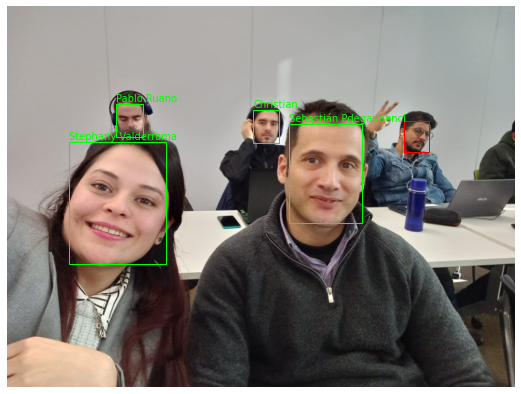

In [74]:
# Reconocimiento en imágenes
# ==============================================================================
# Detectar si se dispone de GPU cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(F'Running on device: {device}')

# Identificar las personas en la imagen
fig, ax = plt.subplots(figsize=(12, 7))
imagen = Image.open('/content/drive/MyDrive/images_cv/imagen_4.jpeg')

pipeline_deteccion_imagen(
    imagen = imagen,
    dic_referencia        = dic_referencias,
    min_face_size         = 20,
    thresholds            = [0.6, 0.7, 0.7],
    min_confidence        = 0.5,
    threshold_similaridad = 0.6,
    device                = device,
    ax                    = ax,
    verbose               = True
)

Running on device: cpu


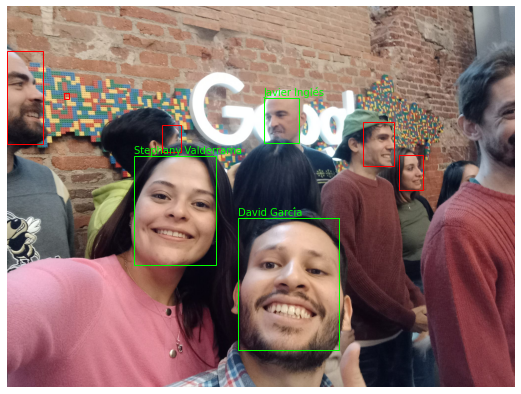

In [75]:
# Reconocimiento en imágenes
# ==============================================================================
# Detectar si se dispone de GPU cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(F'Running on device: {device}')

# Identificar las personas en la imagen
fig, ax = plt.subplots(figsize=(12, 7))
imagen = Image.open('/content/drive/MyDrive/images_cv/imagen_11.jpeg')

pipeline_deteccion_imagen(
    imagen = imagen,
    dic_referencia        = dic_referencias,
    min_face_size         = 20,
    thresholds            = [0.6, 0.7, 0.7],
    min_confidence        = 0.5,
    threshold_similaridad = 0.6,
    device                = device,
    ax                    = ax,
    verbose               = True
)

# Reconocimiento en vídeo




In [76]:
# Reconocimiento en vídeo
# ==============================================================================
pipeline_deteccion_video(
    path_input_video      = '/content/drive/MyDrive/images_cv/videos/video_1.mp4',
    path_output_video     = '/content/drive/MyDrive/images_cv/videos/video_1_processed.mp4',
    dic_referencia        = dic_referencias,
    threshold_similaridad = 0.4,
)

100%|██████████| 94/94 [01:01<00:00,  1.54it/s]


# Reconocimiento en webcam

In [ ]:
# pipeline_deteccion_webcam(
#     dic_referencia        = dic_referencias,
#     threshold_similaridad = 0.4,
# )

#  Información de sesión

In [ ]:
from sinfo import sinfo
sinfo()
